In [110]:
import yfinance as yf
import matplotlib.pyplot as plt
import os
import pandas as pd
from pycoingecko import CoinGeckoAPI
import time

# Set working directory
os.chdir("/home/david/btc-analysis")

# Open previously saved CSV file that goes all the way back to 2010
df_c = pd.read_csv(r"data/bitcoin_data.csv")

# Clean it up
df_c.drop(columns=["End"], inplace=True)  
df_c.drop(columns=["Market Cap"], inplace=True)  
df_c.rename(columns={"Start": "Date"}, inplace=True)  # Rename 'Start' to 'Date'
df_c["Date"] = pd.to_datetime(df_c["Date"], format='%Y-%m-%d')  # Convert 'Date' to datetime
numeric_cols = df_c.select_dtypes(include=['float64', 'int64']).columns
df_c[numeric_cols] = df_c[numeric_cols].round(2)


# Define function that updates the saved csv with the latest data from Yahoo Finance
def update_dataframe(df):
    last_date = df['Date'].max() + pd.Timedelta(days=1)
    print(f"Last date in DataFrame: {last_date}")
    update = yf.download('BTC-USD', start=last_date) 
    update = update.droplevel(1, axis=1)  # Drop a level in a MultiIndex DataFrame
    update = update.reset_index()
    update = update[["Date", "Open", "High", "Low", "Close", "Volume"]]  # Reorder columns
    update.columns.name = None
    numeric_cols = update.select_dtypes(include=['float64', 'int64']).columns
    update[numeric_cols] = update[numeric_cols].round(1)

    print(update.head())

    new_df = pd.concat([df, update], ignore_index=True)
    new_df = new_df.drop_duplicates(subset='Date', keep='last')
    new_df = new_df.sort_values(by='Date').reset_index(drop=True)

    return new_df

# Function that checks for gaps in the DataFrame and fills them with backup data from CoinGecko
def fill_gaps_with_backup(df):
    df = df.sort_values('Date').reset_index(drop=True)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
    missing_dates = all_dates.difference(df['Date'])
    
    if missing_dates.empty:
        print("No gaps—skipping backup.")
        return df
    
    print(f"Gaps found: {missing_dates}")
    cg = CoinGeckoAPI()
    
    rows = []
    for date in missing_dates:
        hist = cg.get_coin_history_by_id('bitcoin', date.strftime('%d-%m-%Y'))
        close = hist['market_data']['current_price']['usd']
        vol = hist['market_data']['total_volume']['usd']
        rows.append({'Date': date, 'Open': close, 'High': close, 'Low': close, 'Close': close, 'Volume': vol})
    backup_df = pd.DataFrame(rows).round(2)
    
    filled_df = pd.concat([df, backup_df]).drop_duplicates('Date').sort_values('Date').reset_index(drop=True)
    return filled_df


updated_df = update_dataframe(df_c)
updated_df = fill_gaps_with_backup(updated_df)

updated_df.to_csv(r"data/bitcoin_data_u.csv", index=False)


/tmp/ipykernel_431137/2833303933.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  update = yf.download('BTC-USD', start=last_date)
[*********************100%***********************]  1 of 1 completed

Last date in DataFrame: 2025-07-24 00:00:00
        Date      Open      High       Low     Close        Volume
0 2025-07-24  118771.0  119535.5  117248.0  118368.0   72627318560
1 2025-07-25  118368.0  118487.0  114759.8  117635.9  104857024569
2 2025-07-27  117953.2  118395.6  117899.0  118252.7   46093242368
Gaps found: DatetimeIndex(['2025-07-26'], dtype='datetime64[ns]', freq='D')


In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer

os.chdir("/home/david/btc-analysis")


data = pd.read_csv(r"data/bitcoin_data_u.csv")

data["Date"] = pd.to_datetime(data["Date"], format='%Y-%m-%d')  # Convert 'Date' to datetime

data.set_index('Date', inplace=True)



def calc_ROI(df, period=365):
    """
    Calculate the ROI for a given date and period in days.
    """

    temp = df.copy()
    temp[str(period)+"_days"] = pd.to_datetime(temp.index) + pd.DateOffset(days=period)

    temp[f"price_after_{period}"] = temp["Close"].shift(-period)
    
    temp[f"ROI_{period}"] = round((temp[f"price_after_{period}"] - temp["Close"]) / temp["Close"], 2)

    return temp

per = 730

temp = calc_ROI(data, period=per)

temp['norm_roi'] = np.log(1+temp[f'ROI_{per}'])

temp['rolling_min'] = temp['norm_roi'].rolling(window=1460, min_periods=1).min()
temp['rolling_max'] = temp['norm_roi'].rolling(window=1460, min_periods=1).max()
temp['stretched_roi'] = (temp['norm_roi'] - temp['rolling_min']) / (temp['rolling_max'] - temp['rolling_min'])

qt = QuantileTransformer(output_distribution='uniform')
temp['qt_roi'] = qt.fit_transform(temp[[f'ROI_{per}']])

[ 506 1970 3162 4537] [1.         0.88589941 0.76969737 0.6319653 ]


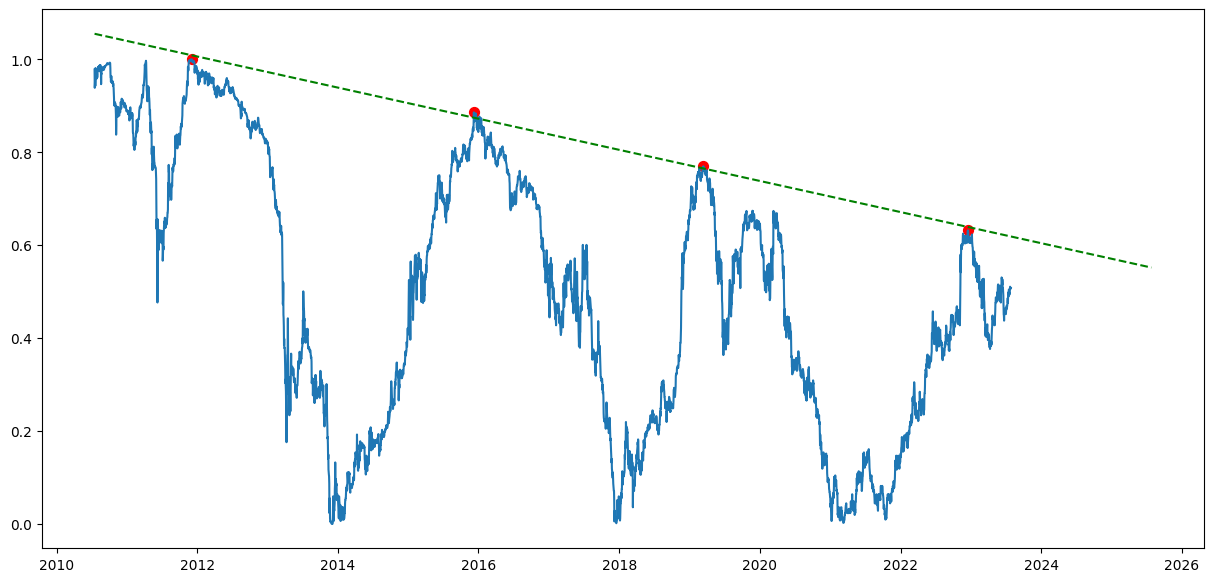

In [120]:
from scipy.signal import find_peaks
import numpy as np

x = temp["qt_roi"].values
y = temp.index

p_indices, _ = find_peaks(x, distance=730, height = 0.5)
p_values = temp.iloc[p_indices]['qt_roi'].values

print(p_indices, p_values)

coef = np.polyfit(p_indices,p_values,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

indices = np.arange(len(temp.index))
fit = poly1d_fn(indices)



fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(temp.index, temp['qt_roi'], label='price color coded by ROI')
ax.scatter(x= temp.iloc[p_indices].index, y=temp.iloc[p_indices]['qt_roi'], color='red', label='Peaks', s=50)
ax.plot(temp.index, fit, color='green', label='Trendline', linestyle='--')

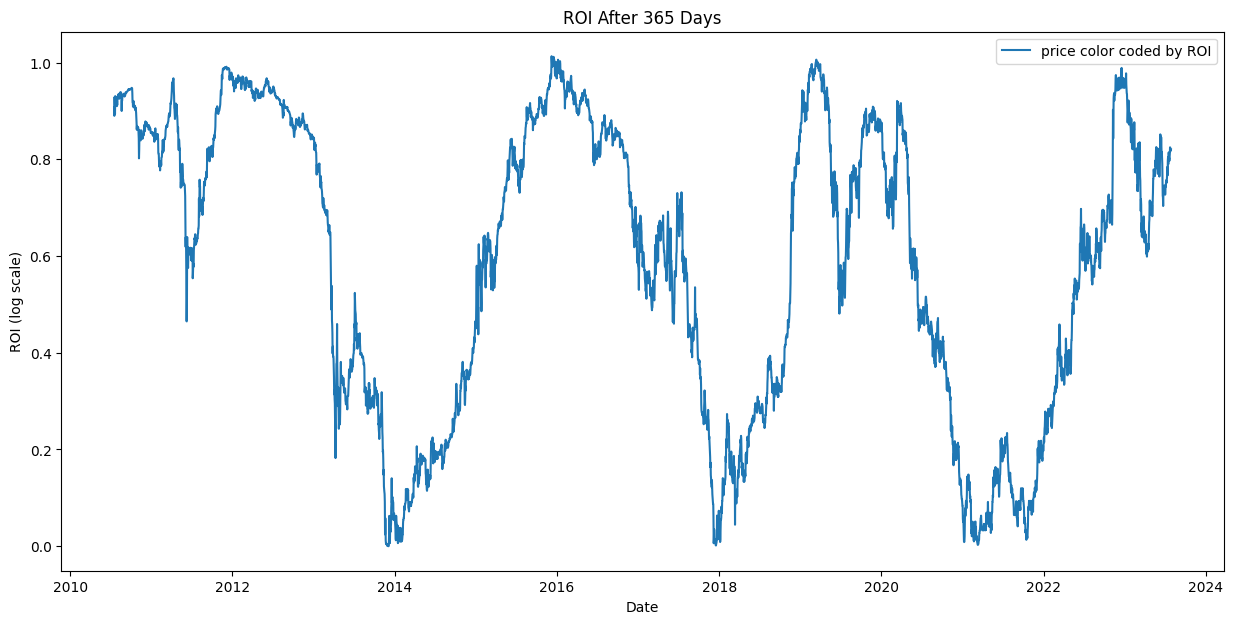

In [122]:
temp["adjusted_log_roi"] = temp['qt_roi'] / fit

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(temp.index, temp['adjusted_log_roi'], label='price color coded by ROI')
ax.set_xlabel('Date')
ax.set_ylabel('ROI (log scale)')
ax.set_title('ROI After 365 Days')
ax.legend()
plt.show()

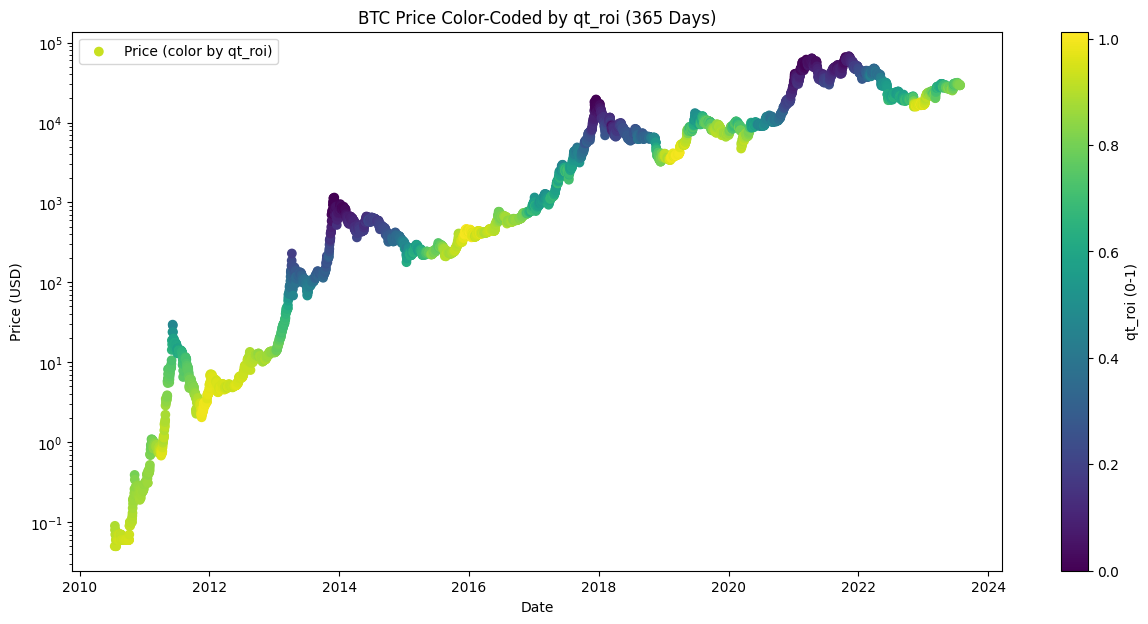

In [123]:
fig, ax = plt.subplots(figsize=(15, 7))
sc = ax.scatter(temp.index, temp['Close'], c=temp['adjusted_log_roi'], cmap='viridis', label='Price (color by qt_roi)')
ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.set_title('BTC Price Color-Coded by qt_roi (365 Days)')
plt.colorbar(sc, ax=ax, label='qt_roi (0-1)')  # Legend for color scale
ax.legend()
plt.show()